### loading packages

In [1]:
import os
import glob
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# webscraping Q data
import json
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os

# plotting/mapmaking
import rasterio
import geopandas as gpd
from rasterio.plot import show as rioshow
from geospatial_functions import get_background_map
from geospatial_functions import reproject_raster
from geospatial_functions import remove_below_0

### specifiying directories

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

### loading needed geospatial layers
these are prepared using data from hydrosheds and dem data

In [3]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
gdf_thiessen      = gpd.read_file(f'{gis_folder}\\Thiessen_prcp.shp',crs="EPSG:26918")
# fixing crs
for layer in [outline,main_rivers,all_rivers, gdf_thiessen]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# More indepth analyses & data can be found on [github](https://github.com/Daafip/ENVM1502-Catchment-model)

# 0. Dataset 
## 0.1.1 & 2 - P

All data is downloaded from:  https://www.ncei.noaa.gov/cdo-web/. The raw data file is too large to be stored, individual station data can be found [here](https://github.com/Daafip/ENVM1502-Catchment-model/tree/main/Data/P/data%20per%20station) in the repo. 

Initially the mean over the whole area was taken, however this removes the peaks. To combat this thiessen polygons were made to make a better representation of the data. This can be found in notebook [0.1.2](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.1.2.P_splitting_into_theissen.ipynb)

**load in station data:**

In [4]:
df_lst_input = []
station_lst = []
station_index_dict= {}

files = glob.glob(f"{data_folder}\\P\\data per station\\*_prcp.csv")
for index, file in enumerate(files):
    df = pd.read_csv(file, index_col='DATE', usecols=['DATE', 'PRCP', 'STATION', 'LATITUDE', 'LONGITUDE'],  delimiter=',', parse_dates=True)
    station_lst.append([df.iloc[0].STATION,df.iloc[0].LATITUDE, df.iloc[0].LONGITUDE])
    df_lst_input.append(df)
    station_index_dict[f"{df.iloc[0].STATION}"] = index

**combine raw data into layer**

In [5]:
station_arr = np.array(station_lst)
df_stations = pd.DataFrame(data=list(zip(station_arr[:,0], station_arr[:,1],station_arr[:,2])),
                           columns = ['STATION', 'LATITUDE', 'LONGITUDE'],)

geom  = gpd.points_from_xy(df_stations.LONGITUDE,df_stations.LATITUDE)
gdf_stations = gpd.GeoDataFrame(data=df_stations,geometry=geom, crs="EPSG:4326")
gdf_stations_in_area = gdf_stations[gdf_stations.within(outline.iloc[0].geometry)]

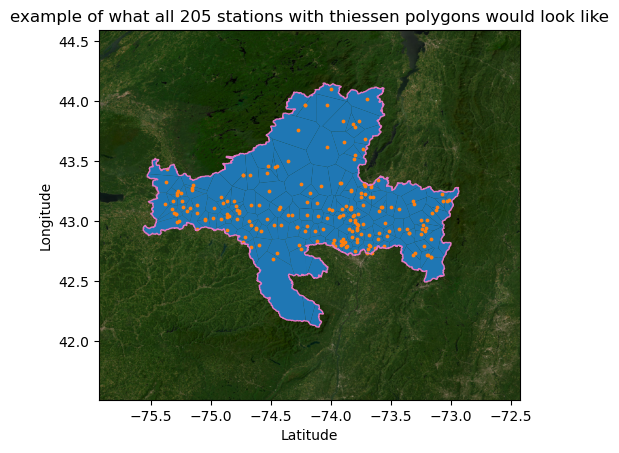

In [6]:
fig, ax = plt.subplots(1)
gdf_thiessen.plot(ax=ax)
gdf_stations_in_area.plot(ax=ax,color="C1",markersize=3) .plot()
outline.plot(ax=ax,edgecolor="C6",facecolor="None")
ax.set_title(f"example of what all {len(gdf_stations_in_area)} stations with thiessen polygons would look like")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

# add background
bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
with rasterio.open(get_background_map("P_stations", bounds_stations)) as r:
    rioshow(r, ax=ax,zorder=-10)

in reality not all stations have data at once, only 4 stations stand between 1950 and 2020, to combat this, we create thiessen polygons for all combinations of stations

In [7]:
gdf_joined = gdf_stations_in_area.sjoin(gdf_thiessen)
lst_dfs_concat = []
for i in gdf_joined.index:
    station_name = gdf_joined.loc[i,"STATION"]
    station_area = gdf_joined.loc[i,"area"]
    df = df_lst_input[station_index_dict[station_name]][["PRCP"]].copy()
    df.rename(columns={'PRCP':f'{station_name}'},inplace=True)
    lst_dfs_concat.append(df)
df_combined = pd.concat(lst_dfs_concat, axis=1)

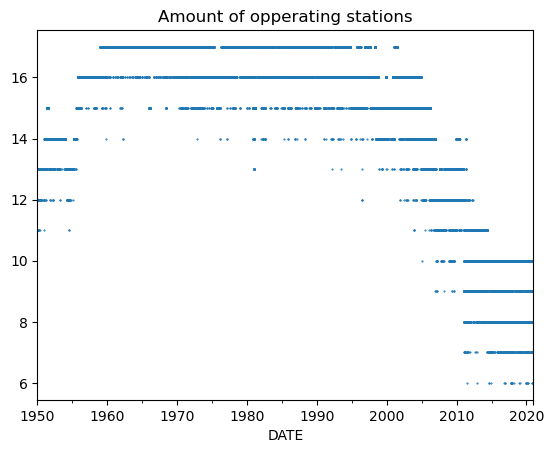

In [8]:
n_year = 50 # threshold for the number of years to be opperating
df_selected_combined = df_combined.loc["1950":"2020"].dropna(axis=1,thresh=365*n_year)
count_nans = df_selected_combined.apply(lambda x: np.isnan([x.loc[col] for col in x.index])).sum(axis=1)
(len(df_selected_combined.columns)- count_nans).plot(lw=0,marker=".",ms=1)
plt.title("Amount of opperating stations");

to speed thing up the threshold was lowered in this case, but a threshold of 20 continous years was used to generate the data set. An example is given below of how the polygon code looks 

In [9]:
# code to create thiessen polygons
from longsgis import voronoiDiagram4plg
def draw_thiessen_polygons(stations, boundary):
    """https://pypi.org/project/voronoi-diagram-for-polygons/"""
    warnings.filterwarnings("ignore", category=FutureWarning)
    vd = voronoiDiagram4plg(stations, boundary)
    return vd

In [10]:
columns = np.array(df_selected_combined.columns.to_list())
series_stations_not_na_txt = df_selected_combined.apply(lambda x: ','.join(columns[~np.isnan([x.loc[col] for col in x.index])]),axis=1)
df_stations_not_na_txt = pd.DataFrame(data=series_stations_not_na_txt,columns=["names_station"])
total_area = outline.to_crs("EPSG:26918").area.sum()
lst_df_joined = []
dict_df_joined = {}
for index, combination in enumerate(df_stations_not_na_txt['names_station'].unique()[:1]):
    ids_to_thiessen = combination.split(",")
    df_station_to_thiessen = gdf_stations_in_area.set_index("STATION").loc[ids_to_thiessen]
    thiessen_polygons = draw_thiessen_polygons(df_station_to_thiessen, outline)
    thiessen_polygons = thiessen_polygons.to_crs("epsg:26918")
    df_station_to_thiessen = df_station_to_thiessen.to_crs("epsg:26918")
    thiessen_polygons["Area_m2"] = thiessen_polygons.area
    df_joined = df_station_to_thiessen.sjoin(thiessen_polygons)
    
    # save the outputs to be used later, dict to get the index, list to store the data
    lst_df_joined.append(df_joined)
    dict_df_joined[combination] = index

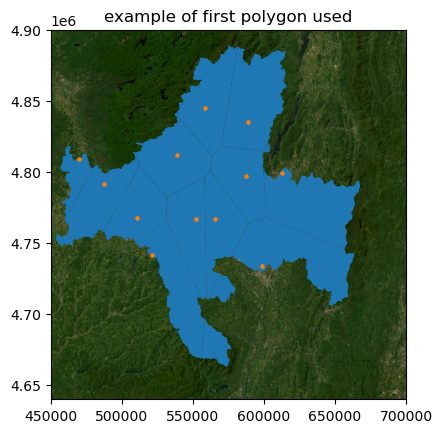

In [11]:
fig, ax = plt.subplots(1)
df_station_to_thiessen.plot(ax=ax, color="C1",zorder=10,markersize=5)
thiessen_polygons.plot(ax=ax)
ax.set_title("example of first polygon used")
    
# add background
old_outline_path = get_background_map("outline", bounds_stations)
background_epsg26918 = reproject_raster(old_outline_path, "epsg:26918",ending="tif")
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-10)
    
ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

With the polygons generated the data can then be added by multiplyin P with the fraction & summing

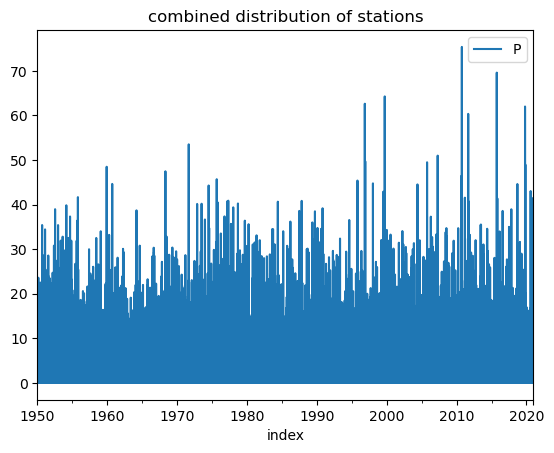

In [12]:
df_p = pd.read_parquet(f"{data_folder}\\P\\weighted_average_P.parquet")

fig, ax = plt.subplots(1)
df_p.plot(ax=ax)
ax.set_title("combined distribution of stations");

## 0.1.3 - T

Similar to P, T was loaded in from station data obtained from https://www.ncei.noaa.gov/cdo-web/. More info in notebook [0.1.3](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.1.3.T_combining_selected_data.ipynb)

In [13]:
gdf_stations = gpd.read_file(f'{gis_folder}\\location_temperature_stations_upperbains_26918.gpkg')

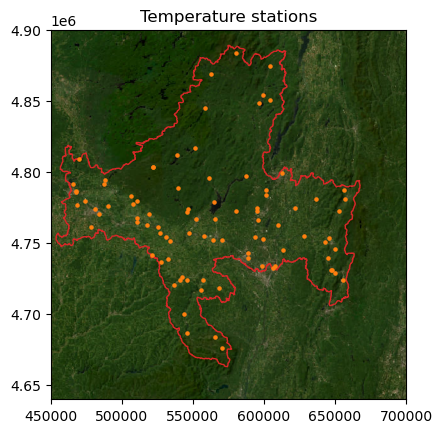

In [14]:
fig, ax = plt.subplots(1)
gdf_stations.plot(ax=ax, color="C1",zorder=10,markersize=5)
outline.to_crs("epsg:26918").plot(ax=ax,edgecolor='C3',facecolor="none")
ax.set_title("Temperature stations")
    
# add background
old_outline_path = get_background_map("outline", bounds_stations)
background_epsg26918 = reproject_raster(old_outline_path, "epsg:26918",ending="tif")
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-10)
    
ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

In [15]:
df_station_ids = gdf_stations[["station ID"]].rename(columns={"station ID":"station_id"})
lst_t_dfs_max = []
lst_t_dfs_min = []
lst_elevation = []
for ids in df_station_ids.station_id.values:
    df_in = pd.read_parquet(f"{data_folder}\\T\\data parquet basin\\temp_{ids}.parquet")
    lst_elevation.append([ids,df_in["ELEVATION"].iloc[0]])
    df_in["DATE"] = pd.to_datetime( df_in["DATE"])
    df_in = df_in.set_index("DATE")
    df_in["TMAX"] = df_in["TMAX"].apply(lambda x: x if (x < 100) else np.nan)
    df_in["TMIN"] = df_in["TMIN"].apply(lambda x: x if (x < 100) else np.nan)
    df_in = df_in.rename(columns={"TMAX":f"TMAX_{ids}","TMIN":f"TMIN_{ids}"})
    df_in_max = df_in.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',f"TMIN_{ids}"])
    df_in_min = df_in.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',f"TMAX_{ids}"])
    lst_t_dfs_max.append(df_in_max)
    lst_t_dfs_min.append(df_in_min)

In [16]:
df_combined_max = pd.concat(lst_t_dfs_max,axis=1)
df_combined_mean_max = df_combined_max.mean(axis=1)

df_combined_min = pd.concat(lst_t_dfs_min,axis=1)
df_combined_mean_min = df_combined_min.mean(axis=1)

<AxesSubplot: xlabel='DATE'>

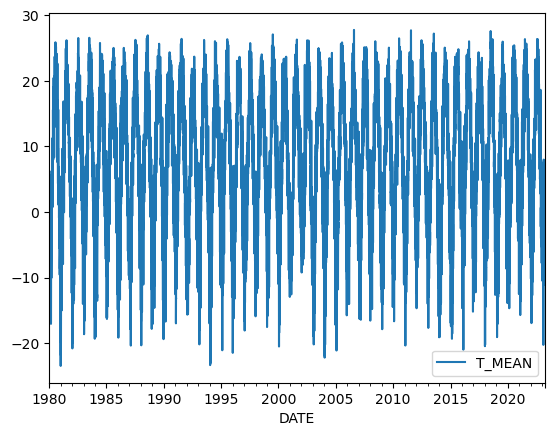

In [17]:
temp_mean_series = (df_combined_mean_max  +  df_combined_mean_min) /2
df_t = pd.DataFrame(data=temp_mean_series,columns=["T_MEAN"])
df_t.loc["1980":].plot()

# 0.2 Q

**From the USGS website we can extract hydrological units for the basin**<br>
[USGS Watershed Boundary Dataset (WBD) for 2-digit Hydrologic Unit - 02 (published 20230306) GeoPackage](https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/GPKG/WBD_02_HU2_GPKG.zip) using [USGS TNM Download (v2.0)](https://apps.nationalmap.gov/downloader/#/)
<!-- ![map]() -->
<img src="Figures\wanted_hydrological_areas.png" alt="Alternative text" width=200/>

**The ids shown on the map can be loaded in**

In [18]:
gdf_wbdhu = gpd.read_file(f"{gis_folder}\\WBDHU8-hudson.gpkg",driver="GPKG",crs="EPSG:4326")  
huc8_ids = ",".join(gdf_wbdhu.huc8.values)
# However we only take the northern part
huc8_ids = ",".join(gdf_wbdhu.iloc[[0,2,3,4,8]].huc8.values)
huc8_ids

'02020002,02020003,02020004,02020001,02020005'

Which we can query

In [19]:
station_id_rest_query = f"https://waterservices.usgs.gov/nwis/dv/?format=rdb&huc={huc8_ids}&parameterCd=00060&siteType=ST&siteStatus=all"
page = urlopen(station_id_rest_query)
html_bytes = page.read()
html = html_bytes.decode("utf-8")

& process

In [20]:
# the 15th line contains the number of sites:
skip_rows = 15
line = html.split("\n")[skip_rows]
print(line)
n = int(line[line.find("following ")+len("following "):line.find(" site")].strip())

data = html.split("\n")[skip_rows+1:skip_rows+1+n]
data_ordered = []
for line in data:
    words = line[line.find("USGS"):].split(" ")
    type_id_name = words[:2] + [" ".join(words[2:])]
    data_ordered.append(type_id_name)
df_sites = pd.DataFrame(data=data_ordered,columns=["provider","site_no","name"])
df_sites.site_no = df_sites.site_no.astype(int)

df_sites.head(4)

# Data for the following 103 site(s) are contained in this file


,provider,site_no,name
0,USGS,131199050,FISHING BROOK (COUNTY LINE FLOW OUTLET) NR NEW...
1,USGS,1311992,ARBUTUS POND OUTLET NEAR NEWCOMB NY
2,USGS,1312000,HUDSON RIVER NEAR NEWCOMB NY
3,USGS,1313500,CEDAR R BELOW CHAIN LAKES NR INDIAN LAKE NY


for these site numbers we can get the location & plot them, see notebook [0.2.2](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.2.2.Q_webscrape%20locations%20.ipynb)

In [21]:
def plot_map(gdf_station, ax):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
        
    ax.set_xlim(-75.8,-72.8)
    ax.set_ylim(40.5, 44.5)
    # remove lat/lon markers
    # ax.set_xticks([])
    # ax.set_yticks([])

In [22]:
gdf_station = gpd.read_file(f"{gis_folder}\\discharge_stations.gpk", driver="GPKG")
# fixing indexing
gdf_station.index = gdf_station.apply(lambda x: int(x.site_no[1:]),axis=1)
gdf_station       = gdf_station.drop(columns=["site_no"])

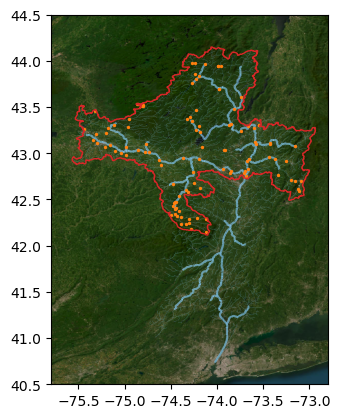

In [23]:
fig, ax = plt.subplots(1)
plot_map(gdf_station, ax)

These sites can then be loaded in, which can be found in notebook [0.2.3](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.2.3.Q_Loading%20discharge%20data.ipynb).<br>
We focussed on station 1358000 as this was at the bottom of the catchement closest to the outflow. 

In [30]:
begin_end_date_csv = f"{data_folder}\\Q_ids_with_begin-end-date.csv"
df_id_dates = pd.read_csv(begin_end_date_csv,index_col=0)
df_id_dates.set_index("ID",inplace=True)

lst_data   = []
lst_errors = []
found_ids  = []

for path in glob.glob(f"{data_folder}\\Q\\*.parquet"):
    df = pd.read_parquet(path)
    # check columns integrity, else this will fail
    df = df[['agency_cd', 'site_no', 'Data codes', 'Q_m3_s_mean','date']]
    df.index = pd.to_datetime(df.date)
    df = df[df["Q_m3_s_mean"]>-999]
    site_no = int(str(df['site_no'].iloc[0])[1:])
    found_ids.append(site_no)
    area = df_id_dates.loc[site_no,"Area_m2"]
    df["Area_USGS"] = area
    df["Q_mm_d"]  = df["Q_m3_s_mean"]  * 86400 / area * 1000  # s -> d, m3 -> mm
    lst_data.append(df)

In [31]:
wanted_index = list(found_ids).index(1358000)
wanted_index

107

In [32]:
def plot_map(ax, station_id):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    
    # remove lat/lon markers
    ax.set_xticks([])
    ax.set_yticks([])
    
    # zoom on one station
    given_station = gdf_station.loc[[station_id]]
    given_station.plot(ax=ax, color="C4",markersize=40)
    x, y = given_station.geometry.x.iloc[0], given_station.geometry.y.iloc[0]
    n = 1
    ax.set_xlim(x- n,x + n)
    ax.set_ylim(y -(2*n/3),y + (2*n/3))


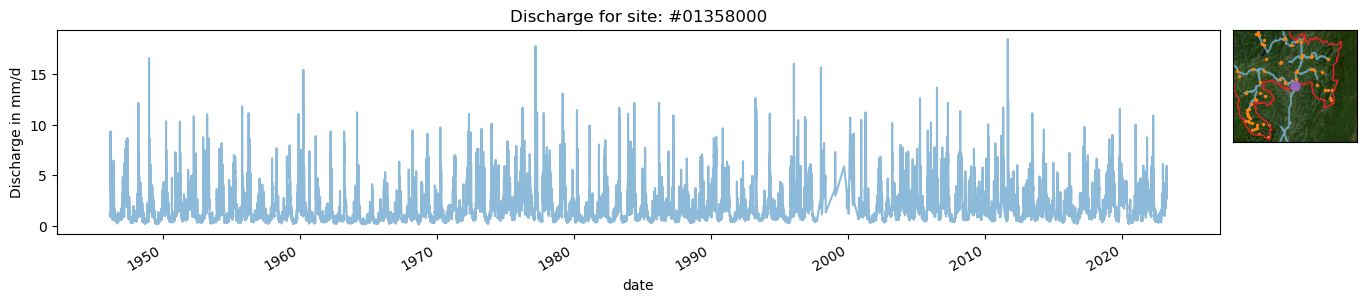

In [36]:
df = lst_data[wanted_index]
fig, ax = plt.subplots(1,figsize=(15,3))
ax2 = ax.inset_axes([.79,.45, 0.55,0.55])
plot_map(ax2, int(df["site_no"].iloc[0]))
df[['Q_mm_d']].plot(ax=ax, alpha=0.5)
ax.set_title(f'Discharge for site: #{df["site_no"].iloc[0]}')
ax.legend().remove()
ax.set_ylabel("Discharge in mm/d");

after a closer look this gaues seems to be missing some data between 1997 & 2001

Text(0.5, 1.0, 'missing data for station 1358000')

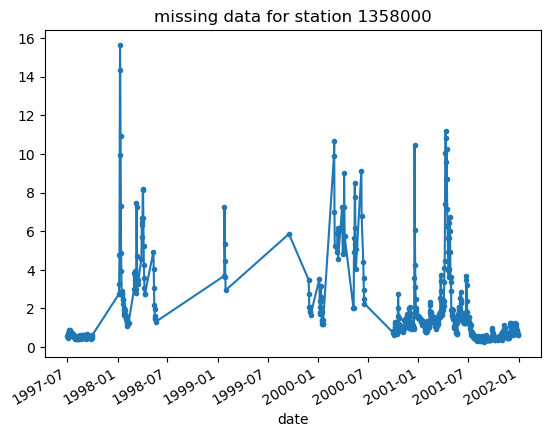

In [38]:
lst_data[wanted_index]["Q_mm_d"].loc["1997-07":"2001"].plot(marker=".")
plt.title("missing data for station 1358000")

Instead opt for adding two gauges together: 01357500 & 01335754 <img src="Figures\river_split.png" alt="Alternative text" width=300 align="left"/>

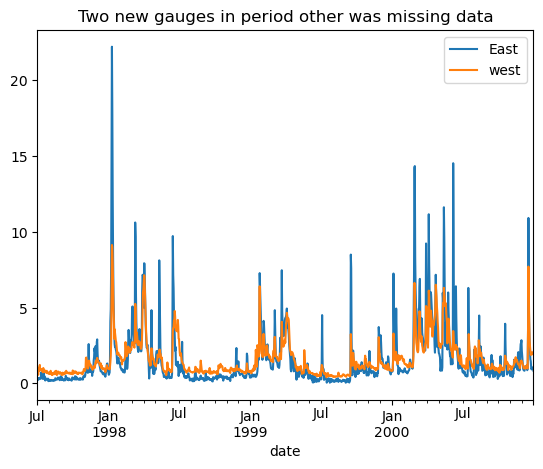

In [44]:
files_Q_East = glob.glob(f"{data_folder}\\Q\\*1357500.parquet")
files_Q_West = glob.glob(f"{data_folder}\\Q\\*1335754.parquet")

discharge_Q_East = pd.read_parquet(files_Q_East[0], columns=['Q_mm_d_hydro','date'])
discharge_Q_East.index = pd.to_datetime(discharge_Q_East.date)
discharge_Q_East.rename(columns={'Q_mm_d_hydro':'Q'}, inplace=True)

discharge_Q_West = pd.read_parquet(files_Q_West[0], columns=['Q_mm_d_hydro','date'])
discharge_Q_West.index = pd.to_datetime(discharge_Q_West.date)
discharge_Q_West.rename(columns={'Q_mm_d_hydro':'Q'}, inplace=True)

ax = discharge_Q_East["Q"].loc["1997-07":"2000"].plot(label="East")
discharge_Q_West["Q"].loc["1997-07":"2000"].plot(ax=ax,label="west")
ax.legend()
ax.set_title("Two new gauges in period other was missing data");

In [46]:
df_combined_E_W = pd.DataFrame(pd.concat([discharge_Q_East[["Q"]],discharge_Q_West[["Q"]]],axis=1).dropna().sum(axis=1),columns=["Q"])

Text(0.5, 1.0, 'Comparison of values')

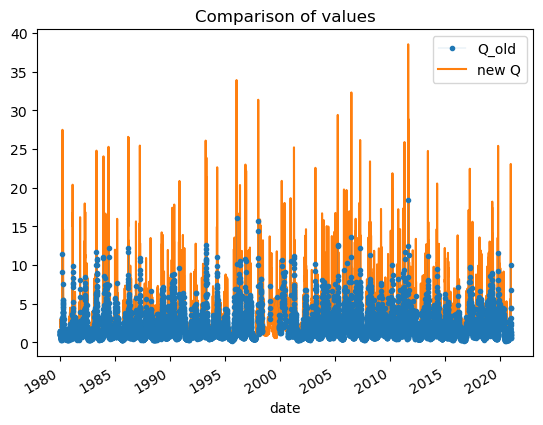

In [52]:
lst_data[wanted_index]["Q_mm_d"].loc["1980":"2020"].plot(lw=0.1,marker=".",zorder=10,label="Q_old")
df_combined_E_W["Q"].loc["1980":"2020"].plot(label="new Q")
plt.legend()
plt.title("Comparison of values")

# 0.3 E_pot
-> handled in 2.5 & 2.6

# 0.4 Combining these four variables 

The gleam data is only availible from the 1980s so this is taken as the begin of the data period

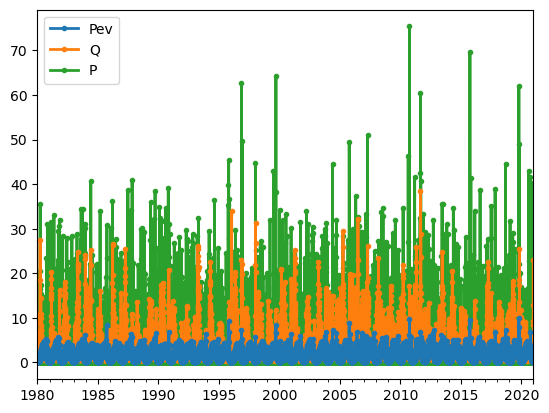

In [55]:
combined_forcing = pd.read_parquet(f"{data_folder}\\combined_data.parquet")
combined_forcing = combined_forcing.loc["1980":"2020"]
for i, col in enumerate(["Pev","Q","P"]):
    combined_forcing[col].plot(lw=2,marker=".",zorder=2-i,label=col)
plt.legend()

In [ ]:
combined_forcing[["Q"]].plot()
plt.xlim(("1999","2001"))

# 1.1 -> to do plot new E data

In [ ]:
def budyko(df_data_1, show=True):
    df_data_1.dropna(inplace=True)
    df_data = df_data_1.copy()
    df_data.Pev = df_data.Pev * 3.5
    
    #Calculate mean
    p_mean = df_data.P.mean()
    q_mean = df_data.Q.mean()
    ep_mean = df_data.Pev.mean()
    
    df_data['Ea_P'] = 1 - df_data['Q'] / df_data['P']
    
    EA_P = 1 - q_mean / p_mean
    EP_P  = ep_mean / p_mean
    fig, ax = plt.subplots()
    ax.plot(EP_P, EA_P, 'o', label=f'Partioning point adjusted Pev')
    
    #Calculate mean
    p_mean = df_data_1.P.mean()
    q_mean = df_data_1.Q.mean()
    ep_mean = df_data_1.Pev.mean()
    
    df_data_1['Ea_P'] = 1 - df_data_1['Q'] / df_data_1['P']
    
    EA_P = 1 - q_mean / p_mean
    EP_P  = ep_mean / p_mean
    
    EP_P_max = int(EP_P + 5)
    EP_P_array = np.linspace(1e-9, EP_P_max, EP_P_max*10)
    
    #Calculate theoretical Budyko
    budyko = (EP_P_array * np.tanh(1 / EP_P_array) * (1 - np.exp(-EP_P_array))) ** 0.5
    budyko_EP = (EP_P * np.tanh(1 / EP_P) * (1 - np.exp(-EP_P))) ** 0.5
    budyko_EA = budyko_EP * p_mean

    dS_dt = p_mean - q_mean - budyko_EA
    
    #Make figure
    ax.plot([0,1], [0,1], 'r')
    ax.plot([1, EP_P_max], [1, 1], 'b')
    ax.set_xlabel('$E_p$/P [-]')
    ax.set_ylabel('$E_A$/P [-]')

    ax.set_title(f'Long term water balance, dS/dT = {dS_dt:.2f} ')
    ax.plot(EP_P, EA_P, 'o', label=f'Partioning point Era5 data')
    ax.plot(EP_P_array, budyko, '--', alpha=0.6, label=f'Budyko (1948) ')
    ax.legend()
    
    if show != True:
        plt.close()

    return df_data, dS_dt

In [ ]:
long_term, dS_dt  = budyko(combined_forcing)

In [ ]:
def flow_duration(df, ax, show=True):
    
    df['Q'].dropna(inplace=True) #Drop the nan values
    df_q = df[["Q"]].rename(columns={"Q":"R"})
    
    df_q.sort_values("R",ascending=False,inplace=True)
    df_q = df_q.reset_index().reset_index()
    df_q.set_index("index",inplace=True)
    df_q.rename(columns={"level_0":"m"}, inplace=True)
    
    n = len(df_q)
    df_q['m'] = df_q.apply(lambda x: x.m+1, axis=1)
    df_q['p'] = df_q.apply(lambda x: x.m / (n+1), axis=1)
    
    # fig, ax = plt.subplots(2,1,figsize=(6,8))
    # fig.tight_layout(h_pad=6)
    
    ax[0].set_ylabel("Runoff Q in [$mm/d$]")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    df[["Q"]].plot(ax = ax[0], color="C0", xlabel='Date')
    
    ax[1].set_ylabel("Runoff Q in [$mm/d$]")
    ax[1].set_xlabel("Excedance probability [-]")
    ax[1].set_title(f"Run off exceedance probability ")
    ax[1].set_yscale("log")
    ax[1].grid()
    ax[1].plot(df_q.p, df_q.R, color="C0")
    
    if show != True:
        plt.close()

    return df_q

In [ ]:
def auto_correlation(df, ax, show=True):
    df.dropna(inplace=True)
    lag = range(50)
    corr_coeff_1 = []
    
    #calculate correlation coefficient for different time lags
    for i in lag:
        corr_coeff_1.append(df['Q'].autocorr(lag=i))
    
    #plot discharge and results
    # fig, ax = plt.subplots(2,1, figsize=(6, 8))
    # fig.tight_layout(h_pad=6)
    df['Q'].plot(ax=ax[0],color="C0")

    ax[0].set_ylabel("Runoff Q in [$mm/d$]")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    
    
    ax[1].plot(lag, corr_coeff_1, color="C0")
    
    ax[1].set_ylabel("Correlation Coefficient $[-]$")
    ax[1].set_xlabel("Time lag $[d]$")
    ax[1].set_title(f"Catchment")
    ax[1].grid()
    
    if show != True:
        plt.close()
    
    return corr_coeff_1

In [ ]:
fig, ax = plt.subplots(2,2)
fig.tight_layout(h_pad=6, w_pad=6)
_ = flow_duration(combined_forcing, [ax[0][0],ax[1][0]])
_ = auto_correlation(combined_forcing,[ax[0][1],ax[1][1]])

# 1.2 - Extreme value analysis

In [ ]:
prcp_df = combined_forcing[["P"]].copy()
prcp_df.dropna()
prcp_df.rename(columns={"P":"PRCP"},inplace=True)
prcp_df = prcp_df[prcp_df.index >  pd.Timestamp("1892-08-01")] # skip gap in data

In [ ]:
def annual_maxima(data):
    idx_max = data.groupby(data.index.year)['PRCP'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

In [ ]:
df_prcp_maxima = annual_maxima(prcp_df).sort_values("PRCP",ascending=False)
df_prcp_maxima.index.name = "time"
df_prcp_maxima.head()

Calculate emperical statistics for these maxima

In [ ]:
#exercise, calculate N and expand you annual maxima dataframe with the columns i, p, q, y, T_a
M = len(df_prcp_maxima)

# indexing tricks to obtain i 
df_prcp_maxima_ranked = df_prcp_maxima.copy().reset_index().reset_index()
df_prcp_maxima_ranked.set_index("time", inplace=True)
df_prcp_maxima_ranked['i'] = df_prcp_maxima_ranked.apply(lambda x: int(x['index']) + 1, axis=1)
df_prcp_maxima_ranked.drop(columns=['index'],inplace=True)

# use i to obtain p
df_prcp_maxima_ranked['p'] = df_prcp_maxima_ranked.apply(lambda x: int(x.i) / (M+1), axis=1)
# q = 1-p
df_prcp_maxima_ranked['q'] = df_prcp_maxima_ranked.apply(lambda x: 1 - x.p, axis=1)

# to compute y = -ln(-ln(q))
df_prcp_maxima_ranked['y'] = df_prcp_maxima_ranked.apply(lambda x: -np.log(-np.log(x.q)), axis=1)

# obtain T_a with 1/p 
df_prcp_maxima_ranked['T_a'] = df_prcp_maxima_ranked.apply(lambda x: 1 / x.p, axis=1)

Calculate statistics for gumbel & fit 

In [ ]:
# exercise: compute Gumbel parameters (name them sigma and mu)
annual_maxima_df_sorted = df_prcp_maxima_ranked.copy()
s_R = annual_maxima_df_sorted['PRCP'].std()
s_y = annual_maxima_df_sorted['y'].std()
y_gem = annual_maxima_df_sorted['y'].mean()
R_max_gem = annual_maxima_df_sorted['PRCP'].mean()

sigma = s_R / s_y
mu = R_max_gem - s_R * y_gem / s_y

print(f'scale parameter σ =  {sigma:.3f}')
print(f'location parameter µ = {mu:.3f}')

In [ ]:
# Now we can construct the Gumbel fit and plot the Gumbel line
dummy_y = np.arange(-2,6.01,0.2)
R_Gumbel = sigma * dummy_y + mu

fig, [ax,ax2] = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(w_pad=3)

ax.plot(annual_maxima_df_sorted['y'].values, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(dummy_y, R_Gumbel, \
        ':og', label = 'Gumbel Estimate')
ax.set_xlabel('Reduced variate y')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

# Here we define the return periods and we inspect the difference between the two return periods
T_interest = np.asarray([0.2, 0.5, 1, 1.2, 1.5, 2, 5, 10, 20, 35, 50, 100, 200, 500, 1000])
T_a_interest = 1 / (1-np.exp(-1/T_interest))
ax2.loglog(T_a_interest,T_interest)
ax2.set_xlabel('return period of exceeding an annual maximum $T_a$')
ax2.set_ylabel('return period $T$')

# real return period for the observed annual maxima
# T_a = 1 / p
# annual_maxima_df_sorted.loc[:,'T_a'] = T_a
# T = -1 / np.log(1 - 1/annual_maxima_df_sorted['T_a'].values)
# annual_maxima_df_sorted.loc[:,'T'] = T
annual_maxima_df_sorted['T'] = df_prcp_maxima_ranked.apply(lambda x: -1 / np.log(1 - (1/ x["T_a"])), axis=1)


In [ ]:
gumbel_estimate = sigma * (- np.log(1/T_interest)) + mu
T = annual_maxima_df_sorted['T'].values

In [ ]:
import mevpy as mev # only works when this "Mevpy" folder is in the folder of this .ipnyb-file (https://github.com/EnricoZorzetto/mevpy)

In [ ]:
# fit GEV parameters (withhout overwriting the sigma and mu from Gumbel)
AMS = annual_maxima_df_sorted['PRCP'].values
xi, sigma_gev, mu_gev = mev.gev_fit(AMS)

F_interest = np.exp(-(1/T_interest))*(1/T_interest)**0

# calculate the GEV estimate for our return periods of interest
gev_estimate = mev.gev_quant(F_interest, xi, sigma_gev, mu_gev)

# convert to dataframe and make a nice table
df_gev_estimate = pd.DataFrame(gev_estimate,columns=['GEV estimate (mm/day)'])
df_gev_estimate.index = T_interest # Return Period

In [ ]:
# create the figure
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(T, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
# ax.plot(T_interest[:-4], full_series, ':Pb', markersize=7, label = 'Full series')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

In [ ]:
prcp_df["YEAR"] = prcp_df.index.year

In [ ]:
# fit mev parameters for each year
N, C, W =  mev.mev_fit(prcp_df, threshold=1)

# put this into a nice dataframe
df_params_mev = pd.DataFrame([N,C,W]).transpose()
df_params_mev.columns = ['N','C','W']

# plotting the CDF curves
dummy_X = np.arange(0,1000,2)

# non-exceedance probability for individual years (here defined as H)
H = np.zeros((len(dummy_X),M))
zeta = np.zeros((len(dummy_X)))

# continue with your own code here:
for i in range(len(zeta)):
    x = dummy_X[i]
    lst = []
    for j in range(len(W)):
        lst.append((1 - np.exp(-(x/C[j])**W[j]))**N[j])
    zeta[i] = 1 / M * np.sum(lst)
    
# x = dummy_X[0]
for j in range(M):
    for i in range(len(H)):
        x = dummy_X[i]
        H[i,j] = (1 - np.exp(-(x/C[j])**W[j]))**N[j]

# plot figure like in Enrico's paper
fig, ax = plt.subplots()
ax.plot(dummy_X, H)
ax.plot(dummy_X, zeta, 'k', linewidth=2, label='MEV')
ax.set_xlabel('Daily rainfall totals x [mm]')
ax.set_ylabel('Non-exceedance probability $\zeta(x)$')
ax.set_xscale('log')
ax.legend()

In [ ]:
# obtain the MEV solution
x0 = np.mean(AMS)
mev_estimate, flags =  mev.mev_quant(F_interest, x0, N, C, W)

if any(flags) == True:
    print('Change starting guess for the numerical solution x0')
elif any(flags) == False:
    print('No errors have been raised, continue the exercise')

In [ ]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
# & including the MEV alternative:
# return periods for the CDF curves
Ta_c = 1/(1-zeta)
T_c  = -1/(np.log(1-(1/Ta_c)))

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.plot(T_interest, mev_estimate, ':sm', label='MEV Estimate')
mask = (T_c<1100) & (T_c > 0)
ax.plot(T_c[mask], dummy_X[mask], 'lightblue', label='MEV alternative')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

# 1.3 - Vegetation

In [ ]:
def water_balance(P, EP, Si_max):

    Si = np.zeros(len(P))
    Pe = np.zeros(len(P))
    for i in range(1, len(P)):
        Si[i] = Si[i-1] + P[i] 


        if Si[i] > Si_max:
            Pe[i] = Si[i] - Si_max
            Si[i] = Si[i] - Pe[i]

        Si[i] = Si[i] - EP[i]
        if Si[i] < 0:
            Si[i] = 0

    df = pd.DataFrame()
    df['P'] = P
    df['EP'] = EP
    df['Si'] = Si
    df['Pe'] = Pe
    return df

def vegetation(df_in, show=True):
    df = df_in.copy()
    df.dropna(inplace=True)
    
    Si_max = 2.5 # mm
    df_wb = water_balance(df.P, df.Pev, Si_max)

    mean_P = df_wb['P'].mean()
    mean_Pe = df_wb['Pe'].mean()
    ratio = mean_Pe / mean_P
    
    #Plot results
    fig, ax = plt.subplots(2, figsize=(10,6))
    df_wb['P'].plot(ax=ax[1])
    df_wb['Pe'].plot(ax=ax[1], ylabel='[mm/d]')

 
    
    df['P'].plot(ax=ax[0], xlabel='Date', ylabel='[mm/d]')
    df['Pev'].plot(ax=ax[0], xlabel='Date', ylabel='[mm/d]')
    df['Q'].plot(ax=ax[0], xlabel='Date', ylabel='[mm/d]')
    
    ax[0].legend() 
    ax[0].set_title(f'Precipitation, Potential Evaporation and Discharge Hudson Basin')
    
    ax[1].set_xlabel('Date')
    ax[1].set_title(f'Interception, with a throughfall ratio of {ratio:.2f}')
    ax[1].legend()
    fig.tight_layout(h_pad=4)
    
    if show != True:
        plt.close()
        
    return ratio, df_wb


In [ ]:
ratio, df = vegetation(combined_forcing)

In [ ]:
def plant_transpiration(df_in, show=True):
    df = df_in.copy()
    from datetime import date, timedelta
    df.dropna(inplace=True)
    
    P_mean = df['P'].mean()
    Q_mean = df['Q'].mean()
    Et_dash = P_mean - Q_mean
    EP_mean = df['Pev'].mean()
    
    df['Et'] = df['Pev'] / EP_mean * Et_dash
    df['Sd'] = np.zeros(len(df['P']))
    
    cumsum = 0 
    
    for i in df['Et'].index:
        cumsum += (df.loc[i,"P"] - df.loc[i,'Et'])
        if cumsum > 0:
            cumsum = 0
        df.loc[i,"Sd"] = np.minimum(0, cumsum)
    
    unique_years = len(df.index.year.unique())
    
    Sr = min(df['Sd'])
    Sr_index = df['Sd'].idxmin()
    
    EP_P = EP_mean / P_mean
    Et_P =  df['Et'].mean() / P_mean
    
    fig, ax = plt.subplots(2,figsize=(8,8))
    fig.tight_layout(h_pad=4)
    #ax2 = ax[0].twinx()  
    df['P'].plot(ax=ax[0], label='Precipitation')
    df['Pev'].plot(ax=ax[0], color='C1', label='Evaporation')
    
    ax[0].legend()
    #ax2.legend()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('[mm/d]');
    
    df['Sd'].plot(ax=ax[1], color='C3')
    ax[1].plot(Sr_index, Sr, 'ro')
    ax[1].text(Sr_index+timedelta(100), Sr, f'SR,{unique_years}y', fontsize=9)
    ax[1].legend()
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Storage deficit [mm]');
    
    if show == True:
        print(f'The vegetation-accessible water storage volume (or root-zone storage capacity) SR,y is {-Sr:.2f} [mm] over the preceding {unique_years} years')
    else:
        plt.close()
    
    return df, Sr, Et_P, EP_P

In [ ]:
df, Sr, Et_P, EP_P = plant_transpiration(combined_forcing)

# 1.4

This only take from 1894, due to missing days and to remove the remove gap between 1988 and 1892

In [ ]:
def align_zeros(axes):
    ylims_current = {}   #  Current ylims
    ylims_mod     = {}   #  Modified ylims
    deltas        = {}   #  ymax - ymin for ylims_current
    ratios        = {}   #  ratio of the zero point within deltas
    for ax in axes:
        ylims_current[ax] = list(ax.get_ylim())
                        # Need to convert a tuple to a list to manipulate elements.
        deltas[ax]        = ylims_current[ax][1] - ylims_current[ax][0]
        ratios[ax]        = -ylims_current[ax][0]/deltas[ax]
        
    for ax in axes:      # Loop through all axes to ensure each ax fits in others.
        ylims_mod[ax]     = [np.nan,np.nan]   # Construct a blank list
        ylims_mod[ax][1]  = max(deltas[ax] * (1-np.array(list(ratios.values()))))
                        # Choose the max value among (delta for ax)*(1-ratios),
                        # and apply it to ymax for ax
        ylims_mod[ax][0]  = min(-deltas[ax] * np.array(list(ratios.values())))
                        # Do the same for ymin
        ax.set_ylim(tuple(ylims_mod[ax]))

In [ ]:
df_all_data_snow_model = combined_forcing.loc[pd.Timestamp("1894-01-01"):]

In [ ]:
df_T_P = df_all_data_snow_model[["T","P"]].dropna(axis=0)

fig, ax = plt.subplots(1,1,figsize=(7,5),sharex=True)
df_T_P[['P']].plot(ax=ax,alpha=1)
ax.set_ylabel("Precipitation in mm")
ax.legend(loc="upper left")

ax2 = ax.twinx()
df_T_P[["T"]].plot(ax=ax2,color="C3",alpha=0.5,zorder=-10)
ax2.legend(loc="upper right")
ax2.set_ylabel("Temperature in $^{\circ}C$")

align_zeros([ax,ax2]);

**Consider elevation data as this correlates with snow**

In [ ]:
fig, ax = plt.subplots(1)
path = f'{gis_folder}\\basin_dem_SRTM.tiff'
new_path = reproject_raster(path, "EPSG:4326")
with rasterio.open(new_path, driver='GTiff') as r:
        rioshow(r, ax=ax)
ax.set_title("DEM of the catchment")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

In [ ]:
with rasterio.open(
    new_path,
    driver='GTiff',
    count=1,
    crs='EPSG:4326' 
                    ) as r:
    dem_data = r.read(1)

From the station data where the temperature is measured

In [ ]:
load_lst_elevation = np.loadtxt(f'{data_folder}\\T\\elevation_stations.txt',delimiter=";",dtype=str)
lst_elevation = load_lst_elevation[:,1].astype(np.float64)

In [ ]:
fig, [ax,ax2] = plt.subplots(1,2,sharex=True,sharey=True,figsize=(5,2))
fig.tight_layout(w_pad=4)

dem_data_in_basin = dem_data[dem_data>-999]
_, __, ___ = ax.hist(np.sort(dem_data_in_basin),density=True);
ax.axvline(np.mean(dem_data_in_basin),color="r")
ax.set_title("Histogram of DEM values")
ax.set_ylabel("Probability density")

_, __, ___ = ax2.hist(lst_elevation,density=True)
ax2.axvline(np.mean(lst_elevation),color="r",label="mean")
ax2.legend()
ax2.set_title("elevation of measurement stations");
ax2.set_ylabel("Probability density")
ax2.set_xlabel("Elevation");

The two histograms above show the distribution of the different elevations. In red the mean is shown. The dem and station measurements are fairly similar, though the stations measure a bit lower

**Start by taking the mean heights and the mean temperature as one flat plane**

In [ ]:
def prev_date(date, days=1):    
    subtracted_date = pd.to_datetime(date) - datetime.timedelta(days=days)
    subtracted_date = subtracted_date.strftime("%Y-%m-%d")
    return subtracted_date

In [ ]:
combined_forcing.plot()

In [ ]:
df = df_T_P.copy()

Er = lst_elevation.mean() #m 
Tt = -0.5 # degc
FM = 3    # mm/deg/d
S_0 = 0 # mm - no snow at start

# for every day:
dt = 1
for i, date in enumerate(df.index):
    P  = df.loc[date,"P"]
    TR = df.loc[date,"T"]
    if i == 0:
        df.loc[prev_date(date),"Ss"] = S_0 # initial amount snow (0) for non exisiting day
        
    # if below threshold temperature, assume not first day for similicity
    if TR < Tt and i != 0:
        df.loc[date,"Pr"] = 0                                                     # no rainfall
        df.loc[date,"Ps"] = P                                                     # precipitation is snow 
        df.loc[date,"M"]  = 0                                                     # Too cold for melt
        df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] + df.loc[date,"Ps"] * dt # add snow to the prev day
        df.loc[date,"Pl"] = 0                                                     # no outflow as too cold
    # then must be above
    else:
        df.loc[date,"Pr"] = P                                                     # all precip is rainfall
        df.loc[date,"Ps"] = 0                                                     # no snow 
        df.loc[date,"M"]  = min(df.loc[prev_date(date),"Ss"]/dt, FM * (TR - Tt))  # calculate melt
        df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] - df.loc[date,"M"] * dt  # remove melted snow
        df.loc[date,"Pl"] = df.loc[date,"Pr"] + df.loc[date,"M"]                  # outflow = rain + melt
        if i == 0:
            df.drop(index=prev_date(date),inplace=True) #  remove initial amount snow for non exisiting day
        
df_case1 = df.copy()

**plot for 1997-1999**

In [ ]:
fig, [ax,ax3] = plt.subplots(2,1,figsize=(12,5),sharex=True)
df_plot = df_case1.loc["1997-09-01":"1999-09-01"]
df_plot[['Ss',"Ps"]].plot(ax=ax)
ax.set_ylabel("Storage in mm")
ax.legend(loc="upper left")

ax2 = ax.twinx()
df_plot[["T"]].plot(ax=ax2,color="C3",alpha=0.5,zorder=-10)
ax2.legend(loc="upper right")
ax2.set_ylabel("Temperature in $^{\circ}C$")

align_zeros([ax,ax2])

df_plot[['Pl']].plot(ax=ax3,color="C2")
ax3.set_ylabel("outflow due to in mm")
ax3.set_title(f"Outflow of snowmodel on one flat plane at {Er:.2f}m");


 **repeat but with different elevation bands**
 As we can see bellow, there is a spread of elevation from 0 to around 1000. these can be split into 4 bands:
1. `elevation < 250`
1. `250 < elevation < 500`
1. `500 < elevation < 750`
1. `750 < elevation`

In [ ]:
fig, ax = plt.subplots(1,sharex=True,sharey=True,figsize=(3,3))

dem_data_in_basin = dem_data[dem_data>-999]
_, __, ___ = ax.hist(np.sort(dem_data_in_basin),density=True);
ax.axvline(np.mean(dem_data_in_basin),color="r")
ax.set_title("Histogram of DEM values")
ax.set_ylabel("Probability density")
ax.annotate(f"$\mu$ ={np.mean(dem_data_in_basin):.1f}m",(np.mean(dem_data_in_basin)+12,0.002),color="red");